In [1]:
using Random
using Random123
using Distributions
using Plots
using StatsPlots
using StatsBase
using Statistics
using DataFrames
using Chain
using Dates
using CSV 
include("Utils.jl")

initialize_prngs

In [3]:
#= Initializing our relevant arguments
loci = 5 # since the bitwidth of the genome is 128, we can't actually model any arbitrary maximum genome bitsize. what we can do instead is enforce a maximum genome size (effectively, the bitwidth within a UInt128). 
#init_active_loci = 3 # how many loci, out of the total number of loci in the landscape defined above, are unlocked at the start?
max_init_genotype_bits = 1 # makes the initial genotype reproducible between resticted and unlocked landscapes of the same size. max size is the number of init active loci
# what the above lets us model is how the restrictedness of the landscape at initialization (init_active_loci) determines what peaks are reached. max_init_genotype_bits allows
# us to control for the initial genotype when we change the number of unlocked loci at the start, otherwise we would just generate a different starting genotype (potentially one that wasn't available on the restricted landscape)
total_population = 1000
σ_epi::Float64 = 0 # standard deviation of the epistatic effects
μ = (total_population^-1)/10 # Mutation rate of the genotypes with some genome. Claudia says than Nμ = 1 is a weird parameter regime, so we adjust it a bit lower
M = 0.0#μ#*10^-1 # rate of genome evolution. expansion/streamlining events happen an order of magnitude less, on average, than mutations
simulation_length = 200000
=#

## 01 Simulating peak-finding on static landscapes

Since a purely additive landscape has 1 fitness maximum, given enough time on any one landscape a population should be able to find it.  

In [2]:
# Initializing our relevant arguments
#loci = 5 # since the bitwidth of the genome is 128, we can't actually model any arbitrary maximum genome bitsize. what we can do instead is enforce a maximum genome size (effectively, the bitwidth within a UInt128). 
#init_active_loci = 3 # how many loci, out of the total number of loci in the landscape defined above, are unlocked at the start?
#max_init_genotype_bits = 1 # how many of the above unlocked loci can be in state "1" (on)? Makes the initial genotype reproducible between resticted and unlocked landscapes of the same size. max size is the number of init active loci
# what the above lets us model is how the restrictedness of the landscape at initialization (init_active_loci) determines what peaks are reached. max_init_genotype_bits allows
# us to control for the initial genotype when we change the number of unlocked loci at the start, otherwise we would just generate a different starting genotype (potentially one that wasn't available on the restricted landscape)
total_population = 1000
σ_epi::Float64 = 0 # standard deviation of the epistatic effects
μ = (total_population^-1)/10 # Mutation rate of the genotypes with some genome. Claudia says than Nμ = 1 is a weird parameter regime, so we adjust it a bit lower
M = 0.0#μ#*10^-1 # There is no genome evolution happening in this case
#simulation_length = 2000
final_genome = DataFrame(Loci = Int[], Replicate = Int[], loci_diff = Int[], Final_fitness = Float64[], Max_fitness = Float64[], Generation = Int[])
runtime = Dates.format(now(), "yyyymmdd_HHMM")
for i in 1:200
    print("\r$i")
    for test in (1, 5, 10, 25, 50, 100) # since no genome evolution, we will treat loci, active_loci, and max_init the same given these sizes
        for generation in (100,200,300,500,800,1000,1500,2000)
            try
                simulation_length = generation
                loci = test
                init_active_loci = test
                max_init_genotype_bits = test
                rng_default, rng_additive, rng_init_genotype, rng_init_genome, rng_mutation = initialize_prngs(additive_seed = i) # changing the additive seed changes the landscape (rng for the drawing of additive components)
                additive_effects = generate_additive_effects(rng_additive, 128)#zeros(128) # we will always need to generate the full range of additive effects (128 bit)
                df_genotypes = simulate(loci, init_active_loci, max_init_genotype_bits, total_population, σ_epi, μ, M, simulation_length, rng_init_genome, rng_init_genotype, rng_default, rng_mutation, additive_effects)
                #generate_plots(df_genotypes)
                sweeps = process_data(df_genotypes, μ, M, additive_effects, σ_epi)[7] # assigns only the data from the selective sweep dataframe
                if nrow(sweeps) > 0
                    #max_fitness = exp(sum(heaviside.(additive_effects[129-loci:end]) .* additive_effects[129-loci:end]))
                    max_fitness = exp(sum(heaviside.(additive_effects[1:loci]) .* additive_effects[1:loci]))
                    final_fitness = get_fitness(sweeps[!,:Genotype][end], sweeps[!,:Genome][end], additive_effects, σ_epi)
                    #genotype_diff = sum(Int.(heaviside.(additive_effects[129-loci:end])) .⊻ digits(sweeps[!,:Genotype][end], base = 2, pad = loci))
                    genotype_diff = sum(Int.(heaviside.(additive_effects[1:loci])) .⊻ digits(sweeps[!,:Genotype][end], base = 2, pad = loci))
                    push!(final_genome, (test, i, genotype_diff, final_fitness, max_fitness, generation)) # genome size of major genotype at end of simulation
                    CSV.write("outputs/data/01_static_additive_landscape_$(runtime).csv", final_genome)
                else 
                    NaN
                end
                
            catch e
                println("\nError at replicate=$i, init_active_loci=$test")
                println(e)
                println(stacktrace(catch_backtrace()))
            end
        end
    end
end

println("\nFinished at: ", Dates.format(now(), "yyyymmdd_HHMM"))

Iteration: 2000
Finished at: 20250808_1012


## 02 Simulating genome sizes at equilibrium

We would expect that since roughly half of the additive effects are positive, that in the simulation these would all get flipped on, while amongst the remaining deleterious effects, half are either on but in the "0" state, or off (in either case, they do not contribute to fitness, and there are no epistatic effects). 

In [10]:
loci = 20 # since the bitwidth of the genome is 128, we can't actually model any arbitrary maximum genome bitsize. what we can do instead is enforce a maximum genome size (effectively, the bitwidth within a UInt128). 
#init_active_loci = 3 # how many loci, out of the total number of loci in the landscape defined above, are unlocked at the start?
max_init_genotype_bits = 1 # makes the initial genotype reproducible between resticted and unlocked landscapes of the same size. max size is the number of init active loci
# what the above lets us model is how the restrictedness of the landscape at initialization (init_active_loci) determines what peaks are reached. max_init_genotype_bits allows
# us to control for the initial genotype when we change the number of unlocked loci at the start, otherwise we would just generate a different starting genotype (potentially one that wasn't available on the restricted landscape)
total_population = 1000
σ_epi::Float64 = 0 # standard deviation of the epistatic effects
μ = (total_population^-1)/10 # Mutation rate of the genotypes with some genome. Claudia says than Nμ = 1 is a weird parameter regime, so we adjust it a bit lower
M = μ#*10^-1 # rate of genome evolution. expansion/streamlining events happen an order of magnitude less, on average, than mutations
simulation_length = 5000
final_genome_sizes = DataFrame(Init_active = Int[], Max_size = Int[], Replicate = Int[], Final_size = Int[], Pos_effects = Int[])
runtime = Dates.format(now(), "yyyymmdd_HHMM")
for i in 1:200
    print("\r$i")
    for init_active_loci in (1, 10, 20)
        try
            rng_default, rng_additive, rng_init_genotype, rng_init_genome, rng_mutation = initialize_prngs(additive_seed = i, mutation_seed = i)
            additive_effects = generate_additive_effects(rng_additive, 128)#zeros(128) # we will always need to generate the full range of additive effects (128 bit)
            df_genotypes = simulate(loci, init_active_loci, max_init_genotype_bits, total_population, σ_epi, μ, M, simulation_length, rng_init_genome, rng_init_genotype, rng_default, rng_mutation, additive_effects)
            #generate_plots(df_genotypes)
            sweeps = process_data(df_genotypes, μ, M, additive_effects, σ_epi)[7] # assigns only the data from the selective sweep dataframe
            if nrow(sweeps) > 0
                push!(final_genome_sizes, (init_active_loci, loci, i, sum(digits(sweeps[!,:Genome][end], base = 2, pad = loci)), Int(sum(heaviside.(additive_effects[1:loci]))))) # genome size of major genotype at end of simulation
                CSV.write("outputs/data/02_expanding_additive_landscape_$(runtime).csv", final_genome_sizes)
            else 
                NaN
            end
        catch e
            println("\nError at replicate=$i, init_active_loci=$init_active_loci")
            println(e)
            println(stacktrace(catch_backtrace()))
        end
    end
end

println("Finished at: ", Dates.format(now(), "yyyymmdd_HHMM"))

Iteration: 5000Finished at: 20250808_1240


## 03 Uniform additive effects

We now run the same simulation but with all additive effects being equivalent (the particular number does not matter in this case, as long as it is not zero), where all additive effects are identical, which has the consequence that no genomic changes have any effect on the landscape, and all landscapes are thus identical. <i>(or at least, it decreases in proportion to the number of loci that have the same effect, since this is the basis for the likelihood that two different random draws of the same size with different loci would have the same total effect)</i>

Not much interesting happens here

In [ ]:
loci = 5 # since the bitwidth of the genome is 128, we can't actually model any arbitrary maximum genome bitsize. what we can do instead is enforce a maximum genome size (effectively, the bitwidth within a UInt128). 
#init_active_loci = 3 # how many loci, out of the total number of loci in the landscape defined above, are unlocked at the start?
max_init_genotype_bits = 1 # makes the initial genotype reproducible between resticted and unlocked landscapes of the same size. max size is the number of init active loci
# what the above lets us model is how the restrictedness of the landscape at initialization (init_active_loci) determines what peaks are reached. max_init_genotype_bits allows
# us to control for the initial genotype when we change the number of unlocked loci at the start, otherwise we would just generate a different starting genotype (potentially one that wasn't available on the restricted landscape)
total_population = 1000
σ_epi::Float64 = 0 # standard deviation of the epistatic effects
μ = (total_population^-1)/10 # Mutation rate of the genotypes with some genome. Claudia says than Nμ = 1 is a weird parameter regime, so we adjust it a bit lower
M = μ#*10^-1 # rate of genome evolution. expansion/streamlining events happen an order of magnitude less, on average, than mutations
simulation_length = 20000
final_genome_sizes = DataFrame(Init_active = Int[], Max_size = Int[], Replicate = Int[], Final_size = Int[], Pos_effects = Int[])
runtime = Dates.format(now(), "yyyymmdd_HHMM")
for i in 100:133
    print("\r$i")
    for init_active_loci in (1, 3, 5)
        try
            rng_default, rng_additive, rng_init_genotype, rng_init_genome, rng_mutation = initialize_prngs(additive_seed = i, mutation_seed = i)
            additive_effects = ones(128)#zeros(128) # we will always need to generate the full range of additive effects (128 bit)
            df_genotypes = simulate(loci, init_active_loci, max_init_genotype_bits, total_population, σ_epi, μ, M, simulation_length, rng_init_genome, rng_init_genotype, rng_default, rng_mutation, additive_effects)
            #generate_plots(df_genotypes)
            sweeps = process_data(df_genotypes, μ, M, additive_effects, σ_epi)[7] # assigns only the data from the selective sweep dataframe
            if nrow(sweeps) > 0
                push!(final_genome_sizes, (init_active_loci, loci, i, sum(digits(sweeps[!,:Genome][end], base = 2, pad = loci)), Int(sum(heaviside.(additive_effects[1:loci]))))) # genome size of major genotype at end of simulation
                CSV.write("outputs/data/13_uniform_additive_landscape_$(runtime).csv", final_genome_sizes)
            else 
                NaN
            end
        catch e
            println("\nError at replicate=$i, init_active_loci=$init_active_loci")
            println(e)
            println(stacktrace(catch_backtrace()))
        end
    end
end

println("Finished at: ", Dates.format(now(), "yyyymmdd_HHMM"))

Iteration: 11000

### 04 Testing individual cases

Namely, do we see a random walk about 75% of the total loci, given the number of beneficial loci is 10?

Iteration: 5000

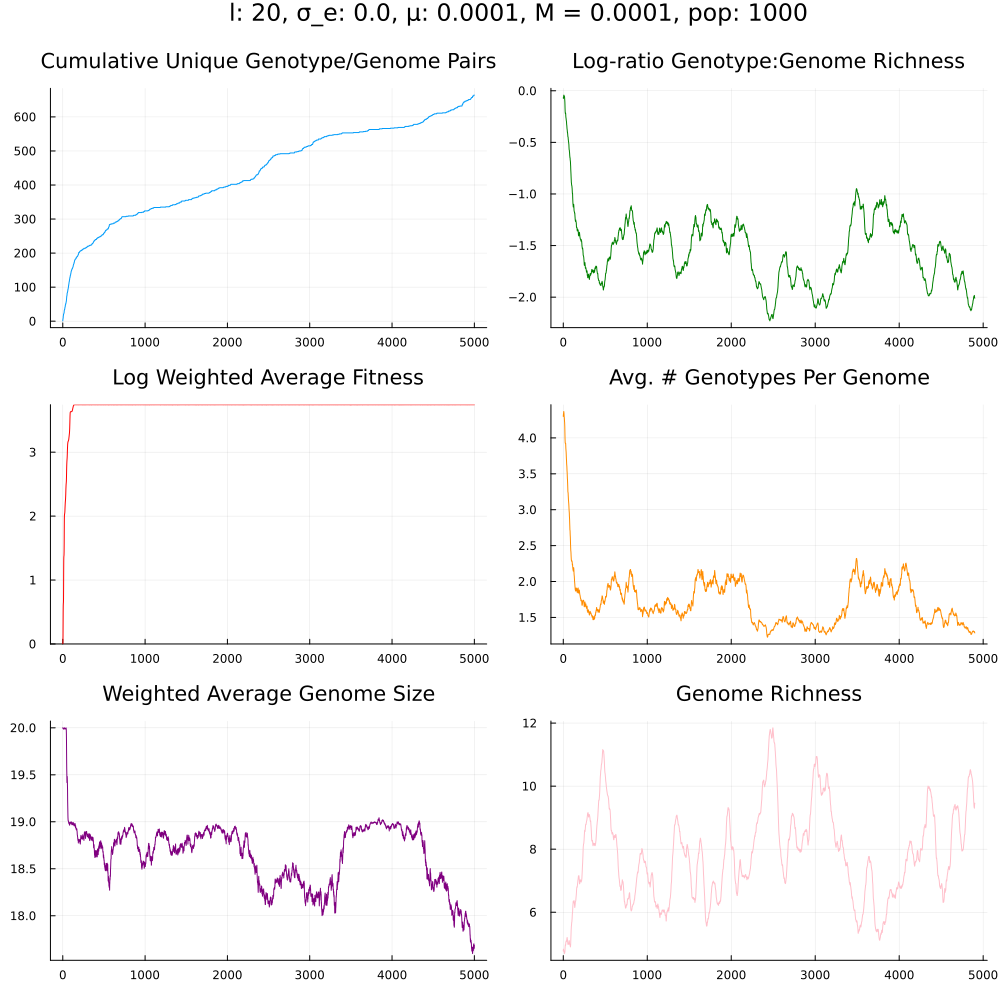

In [9]:
loci = 20
#init_active_loci = 20
max_init_genotype_bits = 1
total_population = 1000
σ_epi::Float64 = 0
μ = (total_population^-1)/10
M = μ
simulation_length = 200000
i = 6 # as identified in section 0.2
df = DataFrame()
for init_active_loci in (1,10,20)
    init_active_loci = 20
    rng_default, rng_additive, rng_init_genotype, rng_init_genome, rng_mutation = initialize_prngs(additive_seed = i, mutation_seed = i)
    additive_effects = generate_additive_effects(rng_additive, 128)#ones(128)#zeros(128) # we will always need to generate the full range of additive effects (128 bit)
    df_genotypes = simulate(loci, init_active_loci, max_init_genotype_bits, total_population, σ_epi, μ, M, simulation_length, rng_init_genome, rng_init_genotype, rng_default, rng_mutation, additive_effects)
    #generate_plots(df_genotypes, μ, M, additive_effects, σ_epi, save = false)
    output_data = process_data(df_genotypes, μ, M, additive_effects, σ_epi)[6]
    insertcols!(df, string(init_active_loci) => output_data[!,:AverageGenomeSize])
    #final_fitness = get_fitness(output_data[!,:Genotype][end], output_data[!,:Genome][end], additive_effects, σ_epi)
    #max_fitness = exp(sum(heaviside.(additive_effects[1:loci]) .* additive_effects[1:loci]))
#end
CSV.write("outputs/data/04_expanding_additive_replicate6_20250724.csv", df)